# Practice

Use the use an ischemic 10X Visium spatial slide from [Kuppe et al., 2022] `kuppe_heart19.h5ad` dataset to practice:
- calculating ligand-receptor interactions per cell type using rank_aggregate method;
- visualize the top 10 ligand-receptor interactions of each cell type;


`kuppe_heart19.h5ad` is a tissue sample obtained from a patient with myocardial infarction, focusing on the ischemic zone of the heart tissue. 
The slide provides spatially-resolved information about the cellular composition and gene expression patterns within the tissue.

### Environement Setup

In [10]:
import pandas as pd
import scanpy as sc
import decoupler as dc
import liana as li
from matplotlib import pyplot as plt
# set dpi to 100, to make the notebook smaller
plt.rcParams['figure.dpi'] = 100
import os

datadir = '../../datasets/Hands_on_2_LIANA_MistY/'

### Load and Normalize Data

In [12]:
adata = sc.read(os.path.join(datadir, 'kuppe_heart19.h5ad'))
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Now, we assign each spot to the cell type with the highest value in 'compositions' by setting adata.obs['cell_type'].

In [13]:
adata.obs['cell_type'] = adata.obsm['compositions'].idxmax(axis=1)

/tmp/ipykernel_1487/2775480619.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
... storing 'cell_type' as categorical


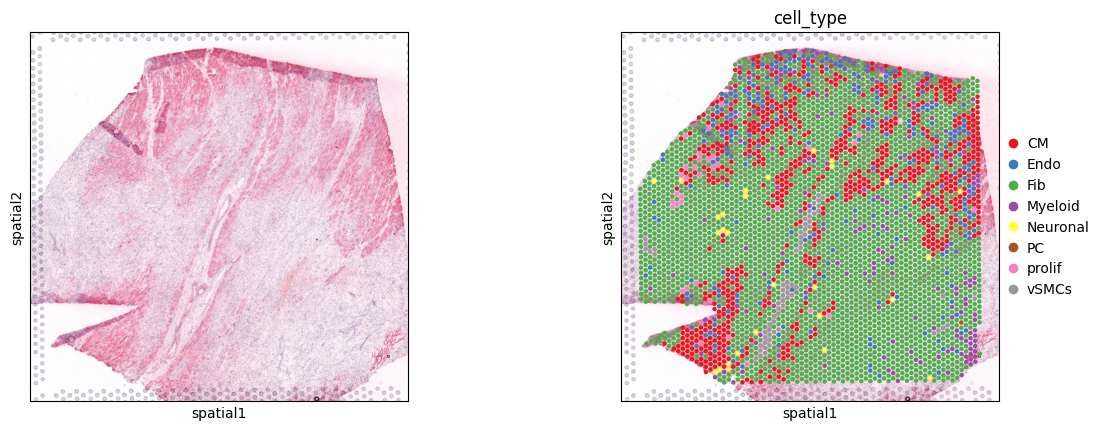

In [14]:
sc.pl.spatial(adata, color=[None, 'cell_type'], size=1.3, palette='Set1') 

### Run rank_aggregate


In [15]:
li.mt.rank_aggregate(adata, 
                     groupby='cell_type',
                     use_raw =False, # we don't have raw in this dataset
                     resource_name='consensus',
                     expr_prop=0.1,
                     verbose=True)

2025-10-31 09:53:04 | [INFO] Using resource `consensus`.
2025-10-31 09:53:04 | [INFO] Using `.X`!
/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/opt/conda/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
2025-10-31 09:53:11 | [INFO] 0.28 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 4113 samples and 1258 features


/opt/conda/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
/opt/conda/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:43<00:00, 22.98it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [16]:
adata.obs['cell_type'].unique()

['Fib', 'CM', 'Endo', 'PC', 'Myeloid', 'Neuronal', 'vSMCs', 'prolif']
Categories (8, object): ['CM', 'Endo', 'Fib', 'Myeloid', 'Neuronal', 'PC', 'prolif', 'vSMCs']

/opt/conda/lib/python3.11/site-packages/liana/plotting/_common.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2025-10-31 09:57:11 | [INFO] Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


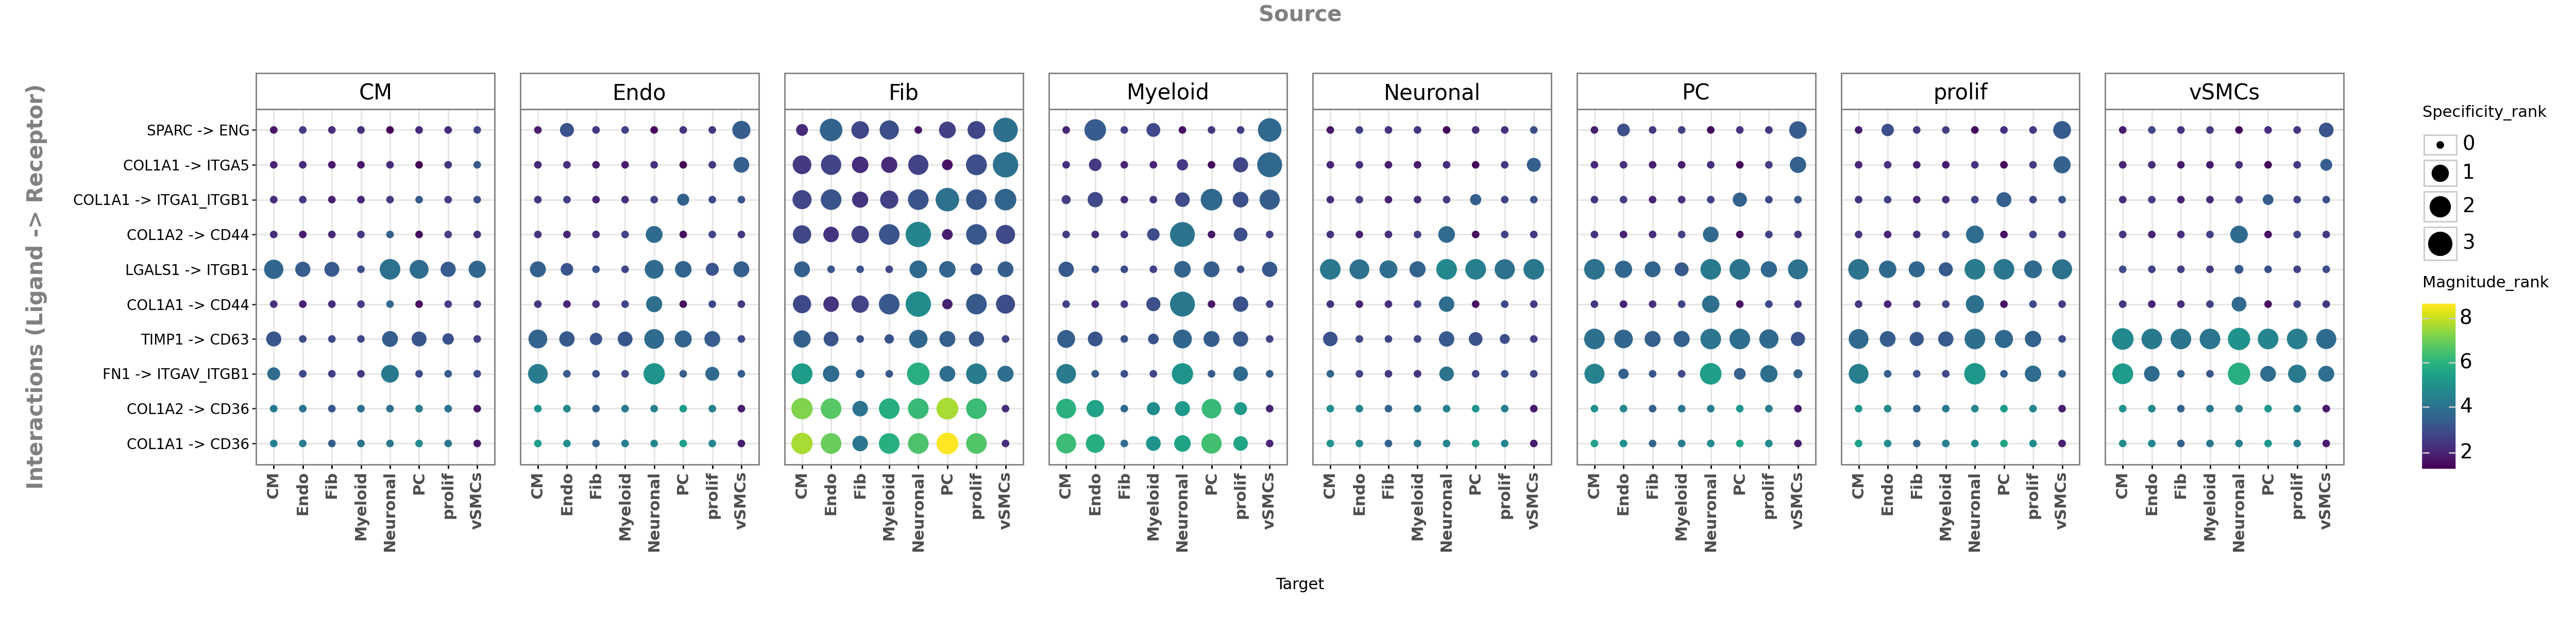

In [17]:
li.pl.dotplot(adata = adata, 
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              source_labels=adata.obs['cell_type'].unique(),
              target_labels=adata.obs['cell_type'].unique(),
              top_n=10, 
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(25, 6)
             )

However, this pipeline does not account for the spatial context of the spots, and each spot represents a mixture of multiple cell types. To incorporate spatial information, we can use the spatially informed bivariate metrics implemented in LIANA+.